In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


# Can you turn yourself into a Simpsons Character?

<table><tr><td><img src='https://drive.google.com/uc?id=1pTuzTcVpPWZnvEtmd4FOg6vdtQ0zIWQh'></td><td><img src='https://drive.google.com/uc?id=1SV5vLt-KrXRmAesBagivP6OlzsFhbsyO'></td></tr></table>

<table><tr><td><img src='https://drive.google.com/uc?id=1jmpktn6Jj9ia_bKpkNzU3A-vtEjRrcpc'></td><td><img src='https://drive.google.com/uc?id=1_t_Gdq8FxdhkF7QVhP_RxCDvO9a-CLjB'></td></tr></table>


[Cyclegan](https://arxiv.org/abs/1703.10593) is a framework that is capable of image to image translatation. It's been applied in some really interesting cases. Such as converting [horses to zebras](https://camo.githubusercontent.com/69cbc0371777fba5d251a564e2f8a8f38d1bf43f/68747470733a2f2f6a756e79616e7a2e6769746875622e696f2f4379636c6547414e2f696d616765732f7465617365725f686967685f7265732e6a7067) (and back again) and photos of the winter to photos of the summer. 

I thought this could be potentially applied to The Simpsons. I was inspired by sites like https://turnedyellow.com/ and https://makemeyellow.photos/. 

So you would upload a photo of your face and Cyclegan would translate that into a Simpsons Character. 

In this article I describe the workflow required to  'Simpsonise' yourself using Cyclegan. It's worth noting that the [paper](https://arxiv.org/pdf/1703.10593.pdf) explicitly mentions that large geometric changes are usually unsuccessful. 

But I'm going to attempt this anyway.



# Install

First we need to install Cyclegan

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2326 (delta 2), reused 7 (delta 2), pack-reused 2318
Receiving objects: 100% (2326/2326), 8.09 MiB | 30.45 MiB/s, done.
Resolving deltas: 100% (1492/1492), done.


In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 686kB 5.9MB/s 
     |████████████████████████████████| 204kB 36.9MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655251 sha256=64af12152de737fdc431eb244e464942d1572cffbde2bdb9e9177786c43c7595
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=48a5e9159aafffba89cf64721fd374641e7ae915a81021da3212a1f77a1183fe
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


# Datasets

Creating the dataset is harder than you would initially think.

To create this dataset I needed to find close up shots of Simpsons characters and close up shots of regular people.

 

In [ ]:
LIMIT = 10000
one_epoch = ((LIMIT/100) * 50)/60 
EPOCHS = 10
print(f'{EPOCHS} epochs would take {one_epoch*EPOCHS/60} hours')

10 epochs would take 13.888888888888888 hours


In [ ]:
from pathlib import Path
from fastai import *
import glob
from fastai.vision import *

TRAIN_A_NAME = 'simpsons_faces'
TRAIN_B_NAME = 'human_face'
DATASET = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME)
TRAIN_A = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/trainA')
TRAIN_B = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/trainB')
TEST_A = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/testA')
TEST_B = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/testB')
URLS_FILE = 'urls.txt'

!rm -Rf $DATASET
os.makedirs(DATASET, exist_ok = True)
os.makedirs(TRAIN_A, exist_ok = True)
os.makedirs(TRAIN_B, exist_ok = True)
os.makedirs(TEST_A, exist_ok = True)
os.makedirs(TEST_B, exist_ok = True)

### Download Simpsons Faceset

Initially my thinking was to scrape images from google images. Unfortunately to do that it looks like you need a [developer key](https://pypi.org/project/Google-Images-Search/) from google console.

So instead I scraped images from [Bing](https://github.com/gurugaurav/bing_image_downloader). 

This worked to an extent. But it took so *long* to download all the images. And after I looked at the images I noticed that some of them didn't include any faces at all.

Thankfully, I stumbled across a [faceset](https://www.kaggle.com/kostastokis/simpsons-faces) on kaggle that had everything I needed. It contains Simpsons faces extracted from a few seasons. Each image is 200x200 pixels and contains one face. 

This faceset will be stored in the `trainA` folder.

In [ ]:
def create_training_dataset_simpson_faces(download_dir):

  %cd $download_dir

  # download dataset and unzip
  !kaggle datasets download kostastokis/simpsons-faces --force
  !unzip \*.zip
  !rm *.zip
  !cp -a $download_dir/cropped/. $download_dir

  # remove unnecessary folders
  !rm -Rf $download_dir/cropped
  !rm -Rf $download_dir/simplified

  # go back to orig directory
  %cd /content/pytorch-CycleGAN-and-pix2pix

create_training_dataset_simpson_faces(TRAIN_A)

### Download Real Faceset


To create the faceset of real faces I got a little bit experimental.

[Will Kwan](https://www.youtube.com/watch?v=pctzpu_wJyE) recently using [stylegan2](https://github.com/NVlabs/stylegan2) to generate a dataset in one of his recent videos. It seemed to work fairly well for him. So I thought I could do the same thing.

Here's some example faces taken from Nvidi's stylegan2 github repository. As you can see the output from this GAN is fairly photorealistic. 

<div>
<img src="https://miro.medium.com/max/2636/1*WR5OApYceVhZTNhO33csZw.png" width="500" height = "500"/>
</div>

This could turn out far better than scraping the internet for faces. I could create as many faces as I needed for my model. I wouldn't have to download some cumbersome `zip` file.  

This faceset will be stored in the `trainB` folder










#### Stylegan installation

In [ ]:
%cd /content/

%tensorflow_version 1.x
import tensorflow as tf

# Download the code
# !git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/spiyer99/stylegan2
# !pip install tf-nightly-gpu
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run
!nvidia-smi -L

/content
TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 586.72 KiB | 9.62 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/stylegan2
CPU says hello.
GPU says hello.
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0e0f221c-54db-2964-673e-3d6db448356f)


In [ ]:
# Download the model of choice
%cd /content/stylegan2/
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

/content/stylegan2
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


#### stylegan create faceset

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def create_training_dataset_real_faces_stylegan(download_dir):

  # create in batches of 100
  # reduces RAM requirements

  counter = 0
  pbar = tqdm(total = LIMIT)

  while counter < LIMIT:

    seeds = np.random.randint(10000000, size=100)
    imgs = generate_images_from_seeds(seeds, 0.7)

    for img in imgs:
      img.save(download_dir/'real_face_{}.jpg'.format(counter), 'JPEG', quality=100)
      counter+=1
      pbar.update(1)
    del imgs

create_training_dataset_real_faces_stylegan(TRAIN_B)

### Train Test Split

Next we'll need to split the data into training and testing. `testB` will contain real faces that we want to covnert into Simpsons characters. `testA` will contain simpsons characters that we want to convert into real people.



In [ ]:
# move images to a new folder
# `images` is the existing image directory: 
# `new_dir` is the path that the images will be moved to
# `files_limit` is the limit of files that will be moved
def move_all_images_to_new_folder(images, new_dir, files_limit = None):
  files = glob.glob(str(images/'*.*g'))

  if(files_limit is not None):
    files = files[:files_limit]

  for file in files: shutil.move(file, new_dir/os.path.basename(file))

move_all_images_to_new_folder(TRAIN_A, new_dir = TEST_A, files_limit = int(min(LIMIT*0.1, 25)))
move_all_images_to_new_folder(TRAIN_B, new_dir = TEST_B, files_limit = int(min(LIMIT*0.1, 25)))

### See our Training and Testing Data

Let's see the images we're working with. 

9852 imgs in TRAIN_A directory


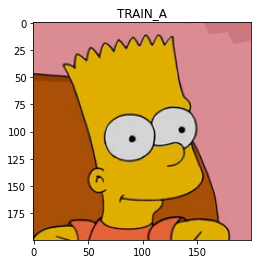

9975 imgs in TRAIN_B directory


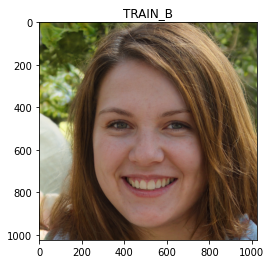

25 imgs in TEST_A directory


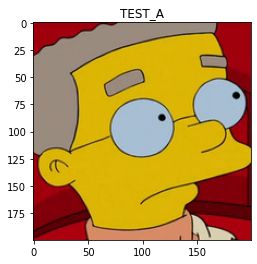

25 imgs in TEST_B directory


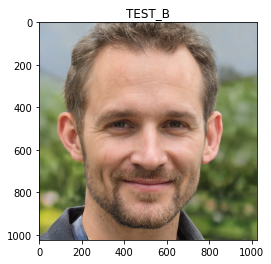

In [ ]:
import PIL
import random

def plot_from_image_path(path, title):

  all_imgs = glob.glob(str(path/'*.*g'))

  print(f'{len(all_imgs)} imgs in {title} directory')

  img_path = random.choice(all_imgs)
  img = PIL.Image.open(img_path)
  plt.imshow(img)
  plt.title(title)
  plt.show()

plot_from_image_path(TRAIN_A, 'TRAIN_A')
plot_from_image_path(TRAIN_B, 'TRAIN_B')

plot_from_image_path(TEST_A, 'TEST_A')
plot_from_image_path(TEST_B, 'TEST_B')

# Creating the model

Now we can create the model. I've made a few adjustments to the [existing script](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/train.py). 

In [ ]:
%cd /content/pytorch-CycleGAN-and-pix2pix

In [ ]:
import gc; gc.collect()
NAME = 'person2simpson'
BATCH_SIZE = 2

Let's create a few helper functions. 

These functions help me copy the saved models to my google drive. It also helps run inference on the model and store the output images to google drive.

In [ ]:
import os
from pathlib import Path
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import random

def copy_to_drive(folder = 'cyclegan_simpsonify'):

  drive_folder = Path('/content/drive/My Drive/')/folder

  if(drive_folder.exists()):
    shutil.rmtree(drive_folder)

  shutil.copytree('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/', str(drive_folder))

def get_corresponding_photo(file_path):
  return file_path.replace('fake', 'real')

def plot_results(number):

  for i in range(number):

    img_path = random.choice(glob.glob('./results/'+NAME+'/test_latest/images/*fake.*g'))
    print(img_path)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title('fake')
    plt.show()

    print(get_corresponding_photo(img_path))
    img = plt.imread(get_corresponding_photo(img_path))
    plt.imshow(img)
    plt.title('real')
    plt.show()

def get_model(src, dst):

  # copy across model
  try:
    os.remove(dst)
  except:
    pass
  shutil.copyfile(src, dst)

def copy_from_drive(folder = 'cyclegan_simpsonify'):

  drive_folder = Path('/content/drive/My Drive/')/folder

  if(not Path('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/').exists()): 
    os.mkdir('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/')

  if(Path('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/').exists()): 
    shutil.rmtree('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

  shutil.copytree(str(drive_folder), '/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

def test_model (number_results = 5, direction = 'BtoA', src = None, dst = None):

  # delete results folder and recrete
  shutil.rmtree('./results')
  os.mkdir('./results')

  # get appropriate model
  if (src is None): src = './checkpoints/'+NAME+'/latest_net_G_'+direction.split('to')[-1]+'.pth'
  if (dst is None): dst = './checkpoints/'+NAME+'/latest_net_G.pth'

  get_model(src, dst)

  if (direction == 'BtoA'):
    test = TEST_B
  else:
    test = TEST_A
  
  cmd = 'python test.py --dataroot '+str(test)+' --name '+str(NAME)+' --model test --no_dropout'
  os.system(cmd)
  plot_results(number_results)


Let's create the options for training. This part is fairly long.

In [ ]:
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import shutil
import os
from pathlib import Path
from tqdm.notebook import tqdm


opt = TrainOptions()  # TODO: TrainOptions().parse(**args) not working. Look into this.
opt.name = NAME
opt.dataroot = TRAIN_A.parent
opt.batch_size=BATCH_SIZE
opt.beta1=0.5
opt.checkpoints_dir='./checkpoints'
opt.continue_train=False
opt.crop_size=256
opt.dataset_mode='unaligned'
opt.direction='BtoA'
opt.display_env='main'
opt.display_freq=400
opt.display_id=1
opt.display_ncols=4
opt.display_port=8097
opt.display_server='http://localhost'
opt.display_winsize=256
opt.epoch='latest'
opt.epoch_count=1
opt.gan_mode='lsgan'
opt.gpu_ids=[0]
opt.init_gain=0.02
opt.init_type='normal'
opt.input_nc=3
opt.isTrain=True
opt.lambda_A=10.0
opt.lambda_B=10.0
opt.lambda_identity=0.5
opt.load_iter=0
opt.load_size=286
opt.lr=2e-4
opt.lr_decay_iters=50
opt.lr_policy='linear'
opt.max_dataset_size=float("inf")
opt.n_epochs=EPOCHS
opt.model = 'cycle_gan'
opt.n_epochs_decay=EPOCHS//2
opt.n_layers_D=3
opt.name=NAME
opt.ndf=64
opt.netD='basic'
opt.netG='resnet_9blocks'
opt.ngf=64
opt.no_dropout=True
opt.no_flip=False
opt.no_html=False
opt.norm='instance' 
opt.num_threads=4
opt.output_nc=3
opt.phase='train'
opt.pool_size=50
opt.preprocess='resize_and_crop' 
opt.print_freq=100
opt.save_by_iter=False 
opt.save_epoch_freq=1
opt.save_latest_freq=5000
opt.serial_batches=False 
opt.suffix=''
opt.update_html_freq=1000
opt.verbose=False

First we create the dataset using the options we specified earlier. 

In [ ]:
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)

dataset [UnalignedDataset] was created
The number of training images = 9975


Then we create the model and run the setup call.

In [ ]:
model = create_model(opt)
model.setup(opt)
visualizer = Visualizer(opt)
total_iters = 0

Setting up a new session...


initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
-----------------------------------------------
create web directory ./checkpoints/person2simpson/web...


Let's see the generator from A to B. The naming convention is slightly different from the [paper](https://arxiv.org/pdf/1703.10593.pdf). In the [paper](https://arxiv.org/pdf/1703.10593.pdf) the generator was called `G`. 

In the code they refer to this mapping function as `G_A`. The meaning is still the same. 

This generator function maps from `A` to `B`. 

In our case it maps from Simpsons to Real Life.

In [ ]:
model.netG_A

DataParallel(
  (module): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (3): ReLU(in

We can see here that the model uses [Resnets](https://arxiv.org/pdf/1512.03385v1.pdf). It has several Resnet blocks. 

We have `Conv2d`, `Batchnorm`, `ReLU`, `InstanceNorm2d` and `ReflectionPad2d`. `InstanceNorm2d` and `ReflectionPad2d` are new to me.

`InstanceNorm2d`: This is very similar to [batch norm](https://arxiv.org/abs/1502.03167) but it is applied to one image at a time. 

`ReflectionPad2d`:  This will pad the tensor using the reflection of the input boundary.

Now we can look at the discriminator as well.

In [ ]:
model.netD_A 

DataParallel(
  (module): NLayerDiscriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )
  )
)

The discriminator uses `LeakyReLU`, `Conv2d` and `InstanceNorm2d`. 

`LeakyReLU` is interesting. `ReLU` is an activation that adds non-linearity to the network. But what is  `LeakyReLU`? 

`ReLU` converts all negative values to `0`. Since, the gradient of `0` is `0` neurons that reach large negative effectively neuron cancel out to `0`. They effectively 'die'. This means that your network eventually stops learning. 

This effect is known as the [dying `ReLU` problem](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks). 

`LeakyReLU` aims to fix this problem. The function is as follows:

`LeakyRELU(x)={ x, if x≥0
 negative_slope×x, otherwise }`
​	
This means if a value is negative mulitply it by `negative_slope` otherwise do nothing. `negative_slope` is usually `0.01`, but you can vary it. 

So `LeakyReLU` signficantly reduces the magnitude of negative values. But the jury is [still out](https://www.quora.com/What-are-the-advantages-of-using-Leaky-Rectified-Linear-Units-Leaky-ReLU-over-normal-ReLU-in-deep-learning/answer/Nouroz-Rahman) on whether this really works well.





#Training

Now we can train the model over a number of epochs. I've specified `10` epochs here.

`model.optimize_parameters()` is where all the magic happens. It optimises the generators. Then it optimises the discriminators. 

The generator takes a horse and tries to generate a zebra. Then it runs the discriminator on the generated zebra and passes this generated zebra to the GAN loss function. It does the same thing for zebras. 

Then we compute the cycle consistency loss. So we take our fake zebra and try to turn it back into a horse. Then we compare this new horse to our original horse. We do the same for zebras. 

We analyse the combined loss which is comprised of the cycle consistency loss and the GAN loss.

After calculating this loss function the model calculates the gradients and updates the weights.

Let's train it!



In [ ]:
# adapted from: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/test.py

for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
    epoch_start_time = time.time()  # timer for entire epoch
    iter_data_time = time.time()    # timer for data loading per iteration
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
    visualizer.reset()              # reset the visualizer: make sure it saves the results to HTML at least once every epoch
    model.update_learning_rate()    # update learning rates in the beginning of every epoch.
    
    for i, data in enumerate(dataset):  # inner loop within one epoch
        iter_start_time = time.time()  # timer for computation per iteration

        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()


    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
        copy_to_drive()
        test_model(1, 'AtoB')
        test_model(1, 'BtoA')

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))


# Testing

I let the model train overnight on [google colab](https://colab.research.google.com/) and copied the `.pth` model to my google drive. 

We'll copy back the weights from google drive to my local computer.

In [ ]:
copy_from_drive()

Then we'll test the model.

./results/person2simpson/test_latest/images/real_face_2224_fake.png


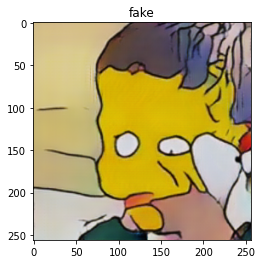

./results/person2simpson/test_latest/images/real_face_2224_real.png


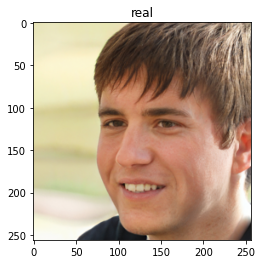

./results/person2simpson/test_latest/images/real_face_8618_fake.png


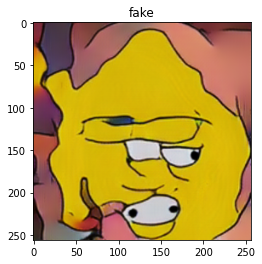

./results/person2simpson/test_latest/images/real_face_8618_real.png


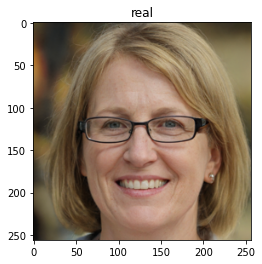

./results/person2simpson/test_latest/images/real_face_7874_fake.png


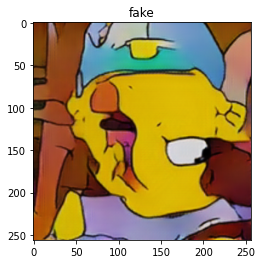

./results/person2simpson/test_latest/images/real_face_7874_real.png


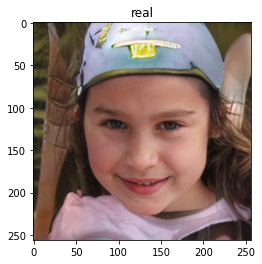

./results/person2simpson/test_latest/images/real_face_818_fake.png


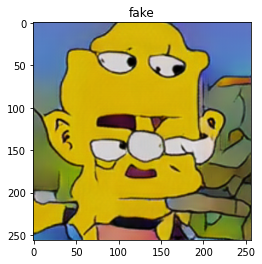

./results/person2simpson/test_latest/images/real_face_818_real.png


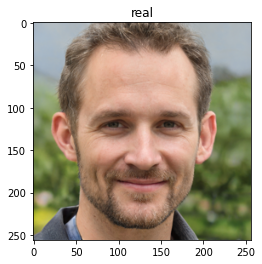

./results/person2simpson/test_latest/images/real_face_9038_fake.png


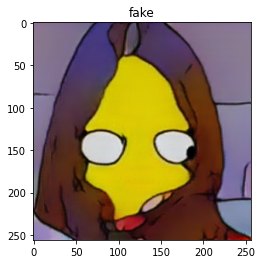

./results/person2simpson/test_latest/images/real_face_9038_real.png


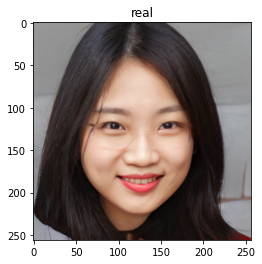

./results/person2simpson/test_latest/images/real_face_8244_fake.png


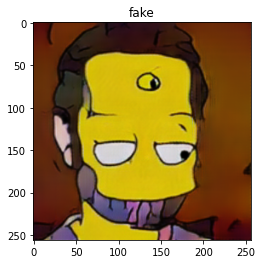

./results/person2simpson/test_latest/images/real_face_8244_real.png


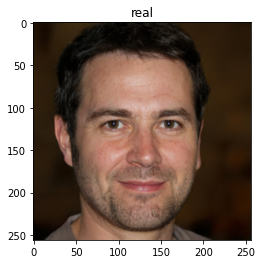

./results/person2simpson/test_latest/images/real_face_3922_fake.png


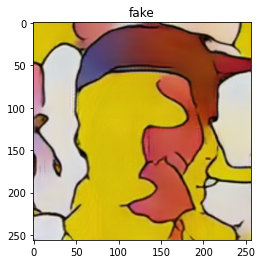

./results/person2simpson/test_latest/images/real_face_3922_real.png


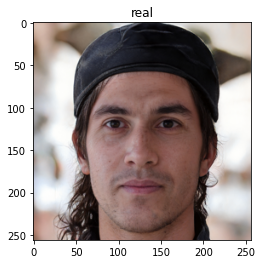

./results/person2simpson/test_latest/images/real_face_9038_fake.png


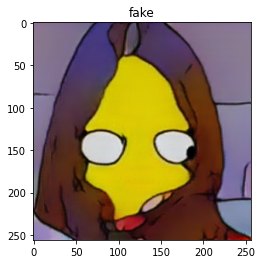

./results/person2simpson/test_latest/images/real_face_9038_real.png


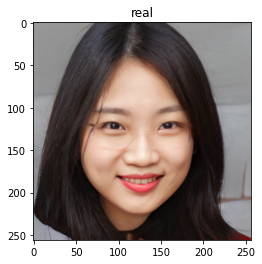

./results/person2simpson/test_latest/images/real_face_8261_fake.png


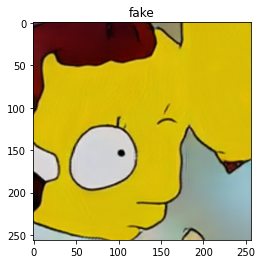

./results/person2simpson/test_latest/images/real_face_8261_real.png


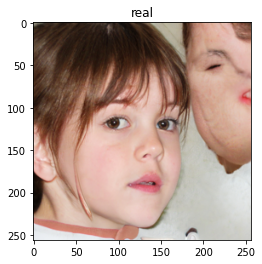

./results/person2simpson/test_latest/images/real_face_475_fake.png


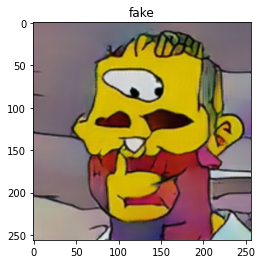

./results/person2simpson/test_latest/images/real_face_475_real.png


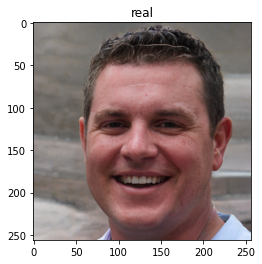

In [ ]:
test_model(10, 'BtoA')

It's a good start. I particularly like this image:


<table><tr><td><img src='https://drive.google.com/uc?id=1pTuzTcVpPWZnvEtmd4FOg6vdtQ0zIWQh'></td><td><img src='https://drive.google.com/uc?id=1SV5vLt-KrXRmAesBagivP6OlzsFhbsyO'></td></tr></table>


But it could use some improvement, to be honest. 

Let's try running the `BtoA` cycle. So we'll convert simpsons characters into human faces.



./results/person2simpson/test_latest/images/1307_fake.png


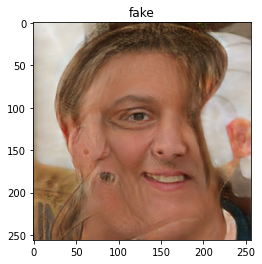

./results/person2simpson/test_latest/images/1307_real.png


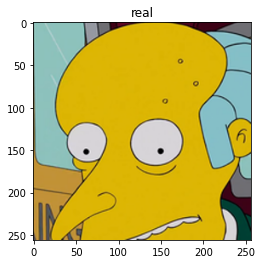

./results/person2simpson/test_latest/images/8899_fake.png


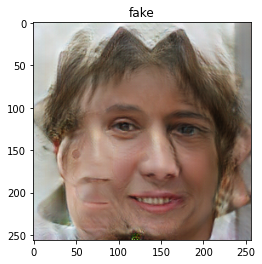

./results/person2simpson/test_latest/images/8899_real.png


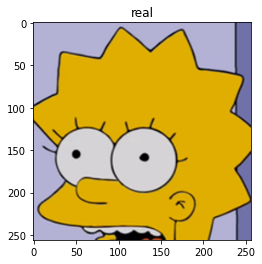

./results/person2simpson/test_latest/images/1535_fake.png


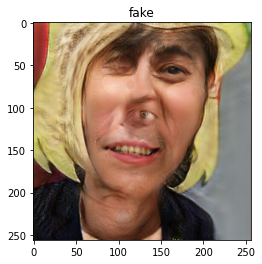

./results/person2simpson/test_latest/images/1535_real.png


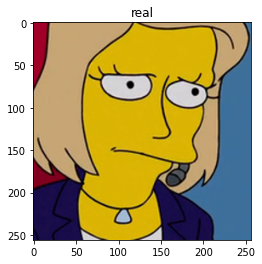

./results/person2simpson/test_latest/images/6737_fake.png


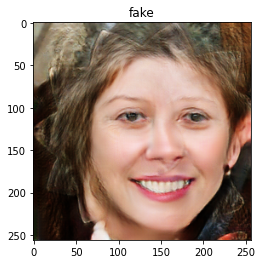

./results/person2simpson/test_latest/images/6737_real.png


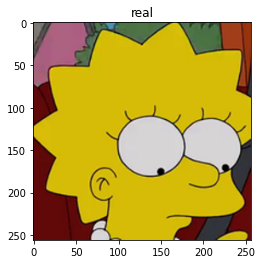

./results/person2simpson/test_latest/images/5121_fake.png


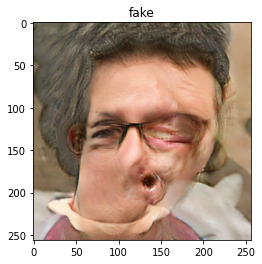

./results/person2simpson/test_latest/images/5121_real.png


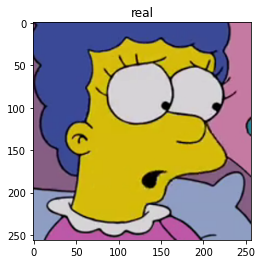

./results/person2simpson/test_latest/images/26_fake.png


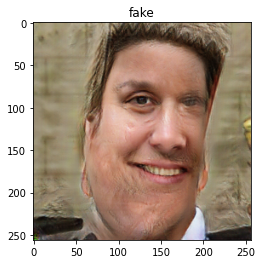

./results/person2simpson/test_latest/images/26_real.png


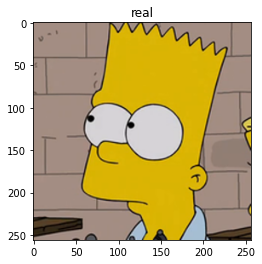

./results/person2simpson/test_latest/images/9759_fake.png


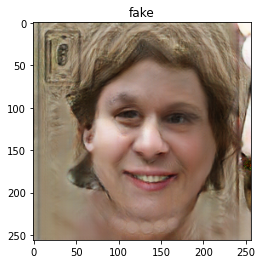

./results/person2simpson/test_latest/images/9759_real.png


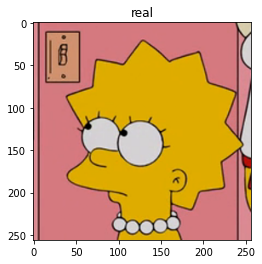

./results/person2simpson/test_latest/images/6064_fake.png


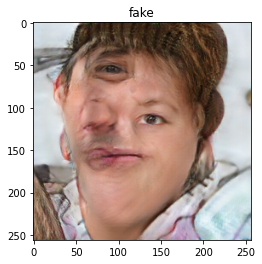

./results/person2simpson/test_latest/images/6064_real.png


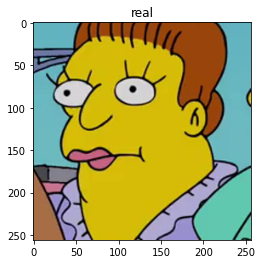

./results/person2simpson/test_latest/images/9759_fake.png


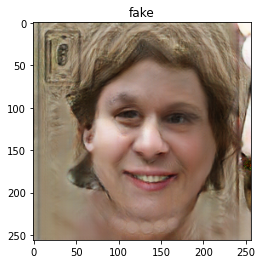

./results/person2simpson/test_latest/images/9759_real.png


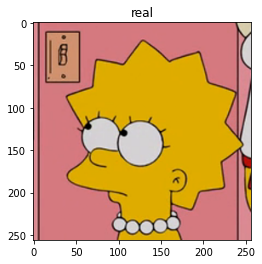

./results/person2simpson/test_latest/images/5716_fake.png


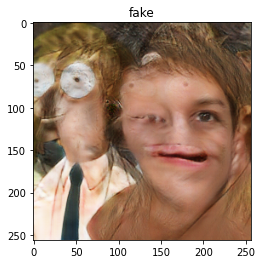

./results/person2simpson/test_latest/images/5716_real.png


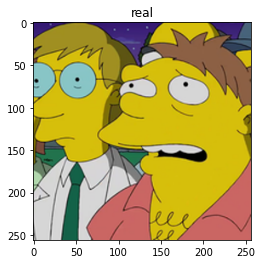

In [ ]:
test_model(10, 'AtoB')

# Improvements

The authors of Cyclegan [noted](https://junyanz.github.io/CycleGAN/) that tasks that require geomtric changes haven't been very successful so far. This notebook confirms this.

The network seems to struggle with the large geometric shifts required to convert a simpsons chartacter to a real person (and vice-versa). I'm unsure if more training would rectify this issue. I doubt it though. Cyclegan seems to work well with things like texture changes, color changes and photo to painting translations. 


# Experiments

Things that didn't work so well.

### Run Face Detection

tensorflow installation issue right now

#### install deepfacelab

In [ ]:
# from: https://github.com/chervonij/DFL-Colab/blob/master/DFL_Colab.ipynb
%cd /content/

!git clone https://github.com/iperov/DeepFaceLab.git

# fix linux warning
# /usr/lib/python3.6/multiprocessing/semaphore_tracker.py:143: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown
fin = open("/usr/lib/python3.6/multiprocessing/semaphore_tracker.py", "rt")
data = fin.read()
data = data.replace('if cache:', 'if False:')
fin.close()

fin = open("/usr/lib/python3.6/multiprocessing/semaphore_tracker.py", "wt")
fin.write(data)
fin.close()

!pip install tensorflow
%tensorflow_version 1.x
!pip install -r /content/DeepFaceLab/requirements-colab.txt
!pip install --upgrade scikit-image
!apt-get install cuda-10-0



#### remove pictures without faces

In [ ]:
def detect_faces(input_path, output_path):

  !rm -Rf $output_path
  os.mkdir(output_path)

  Detector = "S3FD (whole face)" 
  Debug = False

  detect_type = "s3fd"
  dbg = " --output-debug" if Debug else " --no-output-debug"

  cmd = "/content/DeepFaceLab/main.py extract --input-dir "+str(input_path)+" --output-dir "+str(output_path)
  cmd+=" --detector "+detect_type+" --force-gpu-idxs 0"+dbg
  cmd+=" --jpeg-quality "+str(100)+" --max-faces-from-image "+str(0) + " --image-size "+str(512)

  if "whole face" in Detector:
    cmd+=" --face-type whole_face" 

  !python $cmd

  # delete all imgs in input_path folder
  for file in glob.glob(str(input_path/'*.*g')): os.remove(file)

  # move output path imgs to input path folder
  move_all_images_to_new_folder(output_path, new_dir = input_path)

TRAIN_A_FACE_ONLY = TRAIN_A/'face_only'
TRAIN_B_FACE_ONLY = TRAIN_B/'face_only'

detect_faces(TRAIN_A, TRAIN_A_FACE_ONLY)
detect_faces(TRAIN_B, TRAIN_B_FACE_ONLY)

### bing-image-downloader

In [ ]:
!pip install bing-image-downloader

In [ ]:
from bing_image_downloader import downloader
import glob

# move images to a new folder
# `images` is the existing image directory: 
# `new_dir` is the path that the images will be moved to
# `files_limit` is the limit of files that will be moved
def move_all_images_to_new_folder(images, new_dir, files_limit = None):
  files = glob.glob(str(images))

  if(files_limit is not None):
    files = files[:files_limit]

  for file in files: shutil.move(file, new_dir/os.path.basename(file))

%cd $TRAIN_A
downloader.download(TRAIN_A_NAME, limit=LIMIT,  output_dir='.', adult_filter_off=True, force_replace=True, timeout=60)

# move to correct folder
move_all_images_to_new_folder(TRAIN_A/'simpsons', TRAIN_A)

%cd $TRAIN_B
downloader.download(TRAIN_B_NAME, limit=LIMIT,  output_dir='.', adult_filter_off=True, force_replace=True, timeout=60)

# move to correct folder
move_all_images_to_new_folder(TRAIN_B/'person', TRAIN_B)



In [ ]:
move_all_images_to_new_folder(TRAIN_A, new_dir = TEST_A, files_limit = round(LIMIT*0.1))
move_all_images_to_new_folder(TRAIN_B, new_dir = TEST_B, files_limit = round(LIMIT*0.1))

### ai_utils

In [ ]:
%cd /content/pytorch-CycleGAN-and-pix2pix/datasets

In [ ]:
!git clone https://github.com/prairie-guy/ai_utilities

In [ ]:
!pip install -U icrawler python-magic

In [ ]:
!sudo apt-get install libmagic1

In [ ]:
# %%writefile /usr/local/lib/python3.6/dist-packages/icrawler/builtin/google.py

# # -*- coding: utf-8 -*-

# import datetime
# import json
# import re

# from bs4 import BeautifulSoup
# from six.moves.urllib.parse import urlencode

# from icrawler import Crawler, Feeder, Parser, ImageDownloader
# from icrawler.builtin.filter import Filter


# class GoogleFeeder(Feeder):

#     def get_filter(self):
#         search_filter = Filter()

#         # type filter
#         def format_type(img_type):
#             return ('itp:lineart'
#                     if img_type == 'linedrawing' else 'itp:' + img_type)

#         type_choices = ['photo', 'face', 'clipart', 'linedrawing', 'animated']
#         search_filter.add_rule('type', format_type, type_choices)

#         # color filter
#         def format_color(color):
#             if color in ['color', 'blackandwhite', 'transparent']:
#                 code = {
#                     'color': 'color',
#                     'blackandwhite': 'gray',
#                     'transparent': 'trans'
#                 }
#                 return 'ic:' + code[color]
#             else:
#                 return 'ic:specific,isc:{}'.format(color)

#         color_choices = [
#             'color', 'blackandwhite', 'transparent', 'red', 'orange', 'yellow',
#             'green', 'teal', 'blue', 'purple', 'pink', 'white', 'gray',
#             'black', 'brown'
#         ]
#         search_filter.add_rule('color', format_color, color_choices)

#         # size filter
#         def format_size(size):
#             if size in ['large', 'medium', 'icon']:
#                 size_code = {'large': 'l', 'medium': 'm', 'icon': 'i'}
#                 return 'isz:' + size_code[size]
#             elif size.startswith('>'):
#                 size_code = {
#                     '400x300': 'qsvga',
#                     '640x480': 'vga',
#                     '800x600': 'svga',
#                     '1024x768': 'xga',
#                     '2mp': '2mp',
#                     '4mp': '4mp',
#                     '6mp': '6mp',
#                     '8mp': '8mp',
#                     '10mp': '10mp',
#                     '12mp': '12mp',
#                     '15mp': '15mp',
#                     '20mp': '20mp',
#                     '40mp': '40mp',
#                     '70mp': '70mp',
#                 }
#                 return 'isz:lt,islt:' + size_code[size[1:]]
#             elif size.startswith('='):
#                 wh = size[1:].split('x')
#                 assert len(wh) == 2
#                 return 'isz:ex,iszw:{},iszh:{}'.format(*wh)
#             else:
#                 raise ValueError(
#                     'filter option "size" must be one of the following: '
#                     'large, medium, icon, >[]x[], =[]x[] ([] is an integer)')

#         search_filter.add_rule('size', format_size)

#         # licence filter
#         license_code = {
#             'noncommercial': 'f',
#             'commercial': 'fc',
#             'noncommercial,modify': 'fm',
#             'commercial,modify': 'fmc'
#         }

#         def format_license(license):
#             return 'sur:' + license_code[license]

#         license_choices = list(license_code.keys())
#         search_filter.add_rule('license', format_license, license_choices)

#         # date filter
#         def format_date(date):
#             if date == 'pastday':
#                 return 'qdr:d'
#             elif date == 'pastweek':
#                 return 'qdr:w'
#             elif isinstance(date, tuple):
#                 assert len(date) == 2
#                 date_range = []
#                 for date_ in date:
#                     if date_ is None:
#                         date_str = ''
#                     elif isinstance(date_, (tuple, datetime.date)):
#                         date_ = datetime.date(*date_) if isinstance(
#                             date_, tuple) else date_
#                         date_str = date_.strftime('%m/%d/%Y')
#                     else:
#                         raise TypeError(
#                             'date must be a tuple or datetime.date object')
#                     date_range.append(date_str)
#                 return 'cdr:1,cd_min:{},cd_max:{}'.format(*date_range)
#             else:
#                 raise TypeError(
#                     'filter option "date" must be "pastday", "pastweek" or '
#                     'a tuple of dates')

#         search_filter.add_rule('date', format_date)

#         return search_filter

#     def feed(self, keyword, offset, max_num, language=None, filters=None):
#         base_url = 'https://www.google.com/search?'
#         self.filter = self.get_filter()
#         filter_str = self.filter.apply(filters, sep=',')
#         for i in range(offset, offset + max_num, 100):
#             params = dict(
#                 q=keyword,
#                 ijn=int(i / 100),
#                 start=i,
#                 tbs=filter_str,
#                 tbm='isch')
#             if language:
#                 params['lr'] = 'lang_' + language
#             url = base_url + urlencode(params)
#             self.out_queue.put(url)
#             self.logger.debug('put url to url_queue: {}'.format(url))


# class GoogleParser(Parser):

#     def parse(self, response):
#         soup = BeautifulSoup(
#             response.content.decode('utf-8', 'ignore'), 'lxml')
#         image_divs = soup.find_all('script')
#         for div in image_divs:
#             txt = div.string
#             if txt is None or not txt.startswith('AF_initDataCallback'):
#                 continue
#             if 'ds:1' not in txt:
#                 continue
#             # txt = re.sub(r"^AF_initDataCallback\({.*key: 'ds:(\d)'.+data:function\(\){return (.+)}}\);?$",
#             #              "\\2", txt, 0, re.DOTALL)
#             txt = re.sub(r"^AF_initDataCallback\({.*key: 'ds:(\d)'.+data:(.+)}\);?$","\\2", txt, 0, re.DOTALL)

#             meta = json.loads(txt)
#             data = meta[31][0][12][2]

#             uris = [img[1][3][0] for img in data if img[0] == 1]
#             return [{'file_url': uri} for uri in uris]


# class GoogleImageCrawler(Crawler):

#     def __init__(self,
#                  feeder_cls=GoogleFeeder,
#                  parser_cls=GoogleParser,
#                  downloader_cls=ImageDownloader,
#                  *args,
#                  **kwargs):
#         super(GoogleImageCrawler, self).__init__(
#             feeder_cls, parser_cls, downloader_cls, *args, **kwargs)

#     def crawl(self,
#               keyword,
#               filters=None,
#               offset=0,
#               max_num=1000,
#               min_size=None,
#               max_size=None,
#               language=None,
#               file_idx_offset=0,
#               overwrite=False):
#         if offset + max_num > 1000:
#             if offset > 1000:
#                 self.logger.error(
#                     '"Offset" cannot exceed 1000, otherwise you will get '
#                     'duplicated searching results.')
#                 return
#             elif max_num > 1000:
#                 max_num = 1000 - offset
#                 self.logger.warning(
#                     'Due to Google\'s limitation, you can only get the first '
#                     '1000 result. "max_num" has been automatically set to %d. '
#                     'If you really want to get more than 1000 results, you '
#                     'can specify different date ranges.', 1000 - offset)

#         feeder_kwargs = dict(
#             keyword=keyword,
#             offset=offset,
#             max_num=max_num,
#             language=language,
#             filters=filters)
#         downloader_kwargs = dict(
#             max_num=max_num,
#             min_size=min_size,
#             max_size=max_size,
#             file_idx_offset=file_idx_offset,
#             overwrite=overwrite)
#         super(GoogleImageCrawler, self).crawl(
#             feeder_kwargs=feeder_kwargs, downloader_kwargs=downloader_kwargs)

In [ ]:
import icrawler
from icrawler.builtin import GoogleImageCrawler


def start_crawler(Crawler_class:icrawler, path:Path, search_text:str, num_images:int, file_idx_offset=0):
    """Kicks off a icarwler download."""
    crawler = Crawler_class(
            feeder_threads=2,
            parser_threads=2,
            downloader_threads=8,
            storage={'root_dir': path})
    crawler.crawl(keyword=search_text, max_num=num_images, file_idx_offset=file_idx_offset)

def image_download(search_text:str, num_images:int, label:str=None, engine:str='google', image_dir='dataset', apikey=None):

    assert engine=='google' or engine=='bing' or engine=='all' or 'flickr', "usage: -engine=['google'|'bing'|'all','flickr']"
    
    if label is None: label = search_text
    path = Path.cwd()/image_dir/label

    if Path.exists(path):
        response = input(f"'{label}' exists. Overwrite? [Y/n]: ")
        if response is 'Y':
            shutil.rmtree(path)
            os.mkdir(path)
        else:
            print(f"'{label}' unchanged", end='\r')
            # os.mkdir(path)

    if engine == 'google':
        start_crawler(GoogleImageCrawler, path, search_text, num_images)
    elif engine == 'bing':
        start_crawler(BingImageCrawler, path, search_text, num_images)
    elif engine == 'all':
        start_crawler(GoogleImageCrawler, path, search_text, num_images)
        start_crawler(BingImageCrawler, path, search_text, num_images, file_idx_offset='auto')
    elif engine == 'flickr':
        start_flickr_crawler(path, search_text, num_images, apikey)
    else:
        return "engine failure"
        
    # nons = filter_images(path)   # Remove non-jpg images        
    # dups = dedupe_images(path)   # Remove duplicates

    print("**********************************************************")
    print(f"Path:       {path}")
    # print(f"Removed:    {dups} duplicate images")    
    # print(f"Removed:    {nons} non-jpeg images ")
    print(f"Downloaded: {len(list(path.iterdir()))} images")
    print("**********************************************************")

image_download('simpsons', 300)

### image_search

In [ ]:
!pip install image-search

In [ ]:
!image_search google cat --limit 10 --json